# ECE 57000 Assignment 4 Exercise

Name: Garrett Hurst

Prepare the following package for implementation.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

/home/x/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Exercise 1: Positional Encoding (20 points)

## Task 1. Implement Positional Encoding (15 points)

Transformers process input sequences in parallel without an inherent understanding of word position, unlike recurrent neural networks (RNNs) that process sequences step by step. Positional encoding helps transformers gain this positional information by adding a vector to each word embedding that contains information about the word's position in the sequence. Specifically, positional encoding is a deterministic, fixed representation based on sine and cosine functions, and the formula for positional encoding is given as:
$$
\mathrm{PE}(p o s, 2 i)=\sin \left(\frac{p o s}{10000^{2 i / d_{\text {model }}}}\right),
$$
$$
\mathrm{PE}(p o s, 2 i+1)=\cos \left(\frac{p o s}{10000^{2 i / d_{\text {model }}}}\right),
$$
where $pos$ is the position, $i$ is the dimension and $d_{\text{model}}$ is the dimension of the model's embeddings.

In practice, the positional encodings is added to the word embeddings, which is done by first creating a tensor of shape (1, sqeuence_length, d_model) and then adding it to the embeddings. Therefore, each dimension of the positional encoding corresponds to a sinusoid.

If implemented correctly, the output should be like:

Word Embeddings with Positional Encoding:

 tensor([[ 1.4000,  1.0479,  0.2396, -0.4558, -0.5485,  0.0267,  0.8648,  1.3756,
          1.1994,  0.4603],
        [ 1.4000,  1.0479,  0.2396, -0.4558, -0.5485,  0.0267,  0.8648,  1.3756,
          1.1994,  0.4603],
        [ 1.4000,  1.0479,  0.2396, -0.4558, -0.5485,  0.0267,  0.8648,  1.3756,
          1.1994,  0.4603]], dtype=torch.float64)

In [2]:
class PositionalEncoding:
    def __init__(self, d_model, max_len):
        self.d_model = d_model
        self.max_len = max_len
        self.positional_encoding = self._get_positional_encoding()

    def _get_positional_encoding(self):
        """
        Generate a matrix where each row corresponds to the positional encoding for a position.
        """
        # <YOUR CODE HERE>
        P = torch.zeros((self.max_len, self.d_model))
        position = torch.arange(0, self.max_len, dtype=torch.float).unsqueeze(1)  
        div_term = 1 / torch.pow(10000, torch.arange(0, self.d_model, 2, dtype=torch.float) / d_model)       
        P[:, 0::2] = torch.sin(position @ div_term.unsqueeze(1).t())
        P[:, 1::2] = torch.cos(position @ div_term.unsqueeze(1).t())       
        return P
        # <END YOUR CODE>

    def get_encoding(self):
        """
        Returns the positional encoding matrix.
        """
        return self.positional_encoding

def add_positional_encoding(word_embeddings, positional_encodings):
    """
    Add positional encoding to word embeddings.

    Parameters:
    - word_embeddings: (batch_size, seq_len, d_model) input embeddings
    - positional_encodings: (seq_len, d_model) precomputed positional encodings

    Returns:
    - embeddings with positional encodings added.
    """
    # <YOUR CODE HERE>
    return word_embeddings + positional_encodings[:word_embeddings.size(1)]
    # <END YOUR CODE>

# Test positional encoding on a sample embedding

batch_size = 3
seq_len = 10
d_model = 128
word_embeddings = torch.arange(1,129).repeat(batch_size, seq_len, 1).float()
word_embeddings *= 0.1

# Create Positional Encoding instance
pos_enc = PositionalEncoding(d_model, seq_len)

# Get positional encoding
positional_encodings = pos_enc.get_encoding()

# Add positional encodings to word embeddings
encoded_embeddings = add_positional_encoding(word_embeddings, positional_encodings)

print("Word Embeddings with Positional Encoding:\n", encoded_embeddings[:,:,3])

Word Embeddings with Positional Encoding:
 tensor([[ 1.4000,  1.0479,  0.2396, -0.4558, -0.5485,  0.0267,  0.8648,  1.3756,
          1.1994,  0.4603],
        [ 1.4000,  1.0479,  0.2396, -0.4558, -0.5485,  0.0267,  0.8648,  1.3756,
          1.1994,  0.4603],
        [ 1.4000,  1.0479,  0.2396, -0.4558, -0.5485,  0.0267,  0.8648,  1.3756,
          1.1994,  0.4603]])


## Task 2: Visualize Positional Encoding (5 points)

Generate and visualize the positional encodings using the positional_encoding function. You will use a heatmap to visualize how different positions and dimensions are represented by the encoding.



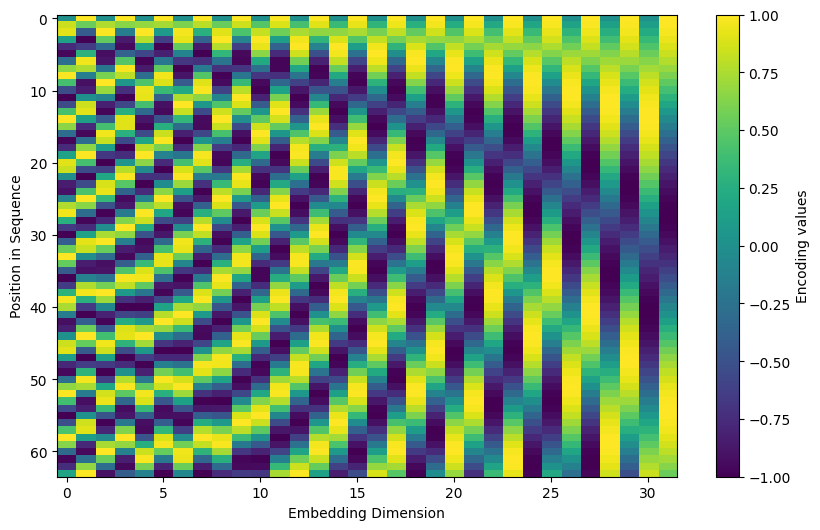

In [3]:
def visualize_positional_encoding(PE):
    plt.figure(figsize=(10, 6))
    plt.imshow(PE, aspect='auto', cmap='viridis')
    plt.colorbar(label="Encoding values")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Position in Sequence")
    plt.show()

# Visualize for a sequence of length 64 and embedding size 32
# <YOUR CODE HERE>
enc = PositionalEncoding(32, 64)
visualize_positional_encoding(enc.get_encoding())
# <END YOUR CODE>

# Exercise 2: Attention Score Function (30 points)

## Task 1. Implement Scaled Dot-Product Attention (20 points)

In this task, you will implement a function that computes scaled dot-product attention and use it to create a simple attention-based layer. The scaled dot-product attention computes the attention score by taking the dot product of queries $Q$ and keys $K$, scaling by the square root of the key dimension $d_k$, and applying a softmax to compute attention weights. These weights are then used to compute the weighted sum of the values $V$:
$$
\operatorname{A}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V,
$$
where $Q, K \in \mathbb{R}^{L \times d_k}$ and $V \in \mathbb{R}^{L \times d_v}$. Notice that the softmax function is performed column-wise, and the output  of attention should be a matrix $A \in \mathbb{R}^{L \times d_v}$.

Furthermore, you will implement a batched version which takes into account several sequences at the same time, such that $Q, K \in \mathbb{R}^{N \times L \times d_k}$ and $V \in \mathbb{R}^{N \times L \times d_v}$ with $N$ the batch size. To do this, we recommend that you use `torch.bmm` for batched version of matrix multiplication for clarity.

If implemented correctly, the output should be like:

Attention output Shape: torch.Size([20, 5, 64])

Attention Weights Shape: torch.Size([20, 5, 5])

Is the implementation close to PyTorch implementation? True


In [4]:
def att_score(Q, K, V):
    """
    Computes scaled dot-product attention.

    Parameters:
    Q (torch.Tensor): Query matrix of shape (batch_size, num_heads, seq_len, d_k)
    K (torch.Tensor): Key matrix of shape (batch_size, num_heads, seq_len, d_k)
    V (torch.Tensor): Value matrix of shape (batch_size, num_heads, seq_len, d_v)
    mask (torch.Tensor): Optional attention mask of shape (batch_size, 1, 1, seq_len)

    Returns:
    torch.Tensor: The attention output of shape (batch_size, num_heads, seq_len, d_v)
    """
    d_k = Q.size(-1)
    # <YOUR CODE HERE>
    weights = F.softmax(
        (Q @ K.transpose(-2,-1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32)), 
        dim=-1
    )
    return weights @ V, weights
    # <END YOUR CODE>

# Test the attention function with some random values

batch_size = 20
seq_len = 5
d_k = 512
d_v = 64

Q = torch.rand(batch_size, seq_len, d_k)
K = torch.rand(batch_size, seq_len, d_k)
V = torch.rand(batch_size, seq_len, d_v)

attention_output, attention_weights = att_score(Q, K, V)
attention_output_ref = F.scaled_dot_product_attention(Q, K, V)

print(f"Attention Output Shape:", attention_output.shape)
print(f"Attention Weights Shape:", attention_weights.shape)

print(f"Is the implementation close to PyTorch implementation? " f'{torch.allclose(attention_output,attention_output_ref, atol = 1e-3)}')

Attention Output Shape: torch.Size([20, 5, 64])
Attention Weights Shape: torch.Size([20, 5, 5])
Is the implementation close to PyTorch implementation? True


## Task 2. Masking Mechanism (10 points)

In certain scenarios, we need to prevent the model from "seeing" future tokens, which ensures that the predictions are only based on the previous tokens in the sequence. For instance, When predicting the next word in a sequence, we don't want the model to attend to future words, as it would give the model access to information it shouldn't have.

In this task, you will implement and test a lower-triangular mask, which masks out upper-triangular entries of the score matrix. Notice that the lower-triangular mask is applied before the softmax function, i.e., on $\left(\frac{Q K^T}{\sqrt{d_k}}\right)$. Accordingly, you will need to modify the `attention_score` function in task 1 to take into account such change.

Hint: you may use the `masked_fill` function to mask out lower-triangular entries. Try to use a boolean mask in the implementation.

If implemented correctly, the output should be like:

Is the implementation close to PyTorch implementation?: True


In [5]:
def create_mask(seq_len):
  # <YOUR CODE HERE>
    return torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool))
  # <END YOUR CODE>

def attention_score(Q, K, V, mask=None):
    """
    Computes scaled dot-product attention.

    Parameters:
    Q (torch.Tensor): Query matrix of shape (batch_size, num_heads, seq_len, d_k)
    K (torch.Tensor): Key matrix of shape (batch_size, num_heads, seq_len, d_k)
    V (torch.Tensor): Value matrix of shape (batch_size, num_heads, seq_len, d_v)
    mask (torch.Tensor): Optional attention mask of shape (batch_size, 1, 1, seq_len)

    Returns:
    torch.Tensor: The attention output of shape (batch_size, num_heads, seq_len, d_v)
    """
    d_k = Q.size(-1)
    # <YOUR CODE HERE>
    weights = (Q @ K.transpose(-2,-1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
    if mask is not None:
        if mask.dtype == torch.bool:
            weigts = weights.masked_fill_(mask.logical_not(), float('-inf'))
        else:
            weights += mask
    weights = F.softmax(weights, dim=-1)
    return weights @ V, weights
    # <END YOUR CODE>

# Test the masked attention function

mask = create_mask(seq_len=5)
attention_output, attention_weights = attention_score(Q, K, V, mask=mask)
attention_output_ref = F.scaled_dot_product_attention(Q, K, V, attn_mask=mask)

print(f"Is the implementation close to PyTorch implementation? " f'{torch.allclose(attention_output,attention_output_ref, atol = 1e-3)}')

Is the implementation close to PyTorch implementation? True


# Exercise 3: Self-Attention Module (20 points)



Implement a self-attention module that takes $X$ and computes $Q$, $K$ and $V$ using three linear layers. If implemented correctly, the output should be like:

Output shape: torch.Size([20, 5, 64])

Output shape: torch.Size([20, 5, 64])
Are the outputs permutation-equivalent? True

The following two lines should be identical:

tensor([-0.0166, -0.4199, -0.5860,  0.3721,  0.5411,  0.4073,  0.8418,  0.2554,
        -0.2712,  0.6178, -0.0495, -0.0552,  0.6988, -0.3643,  0.7696],
       grad_fn=<SliceBackward0>)
       
tensor([-0.0166, -0.4199, -0.5860,  0.3721,  0.5411,  0.4073,  0.8418,  0.2554,
        -0.2712,  0.6178, -0.0495, -0.0552,  0.6988, -0.3643,  0.7696],
       grad_fn=<SliceBackward0>)

In [8]:
class SelfAttention(torch.nn.Module):
    def __init__(self, d_in, d_k, d_v):
        """
        Initialize the Self-Attention module.

        Parameters:
        d_in (int): Dimensionality of the input sequence.
        d_k (int): Dimensionality of the queries and keys.
        d_v (int): Dimensionality of the values.
        """
        super(SelfAttention, self).__init__()
        # <YOUR CODE HERE>
        self.W_q = nn.Linear(d_in, d_k)
        self.W_k = nn.Linear(d_in, d_k)
        self.W_v = nn.Linear(d_in, d_v)
        # <END YOUR CODE>

    def forward(self, X, mask=None):
        """
        Compute the self-attention for the input sequence.

        Parameters:
        X (torch.Tensor): Input sequence of shape (batch_size, seq_len, d_model)

        Returns:
        torch.Tensor: Output sequence of shape (batch_size, seq_len, d_model)
        torch.Tensor: Attention weights of shape (batch_size, seq_len, seq_len)
        """
        # <YOUR CODE HERE>
        Q = self.W_q(X)
        K = self.W_k(X)
        V = self.W_v(X)
        out, _ = attention_score(Q, K, V, mask=mask)
        return out
        # <END YOUR CODE>

# Test the self-attention module

torch.manual_seed(40)
batch_size = 20
seq_len = 5
d_in = 32
d_k = 512
d_v = 64

X = torch.ones(batch_size, seq_len, d_in)
self_attention = SelfAttention(d_in, d_k, d_v)
output = self_attention(X)

print("Output shape:", output.shape)

# Check the permutation-equivalent property of self-attention
perm = torch.randperm(seq_len)

permuted_X = X[:, perm, :]

# Forward pass with permuted input
permuted_output = self_attention(permuted_X)

# Apply the same permutation to the original output to compare
repermuted_output = output[:, perm, :]

# Check if the outputs are the same (up to numerical precision)
are_outputs_equivalent = torch.allclose(permuted_output, repermuted_output, atol=1e-3)

print("Are the outputs permutation-equivalent?", are_outputs_equivalent)
print("The following two lines should be identical:")
print(permuted_output[-1,1,:15])
print(repermuted_output[-1,1,:15])

Output shape: torch.Size([20, 5, 64])
Are the outputs permutation-equivalent? True
The following two lines should be identical:
tensor([-0.0166, -0.4199, -0.5860,  0.3721,  0.5411,  0.4073,  0.8418,  0.2554,
        -0.2712,  0.6178, -0.0495, -0.0552,  0.6988, -0.3643,  0.7696],
       grad_fn=<SliceBackward0>)
tensor([-0.0166, -0.4199, -0.5860,  0.3721,  0.5411,  0.4073,  0.8418,  0.2554,
        -0.2712,  0.6178, -0.0495, -0.0552,  0.6988, -0.3643,  0.7696],
       grad_fn=<SliceBackward0>)


# Exercise 4: Multi-head Self-Attention Module (30 points)

Self-attention mechanisms allow a model to focus on different parts of the input sequence while processing each element. In the multi-head attention setup, multiple attention heads are computed in parallel, and their results are concatenated, which allows the model to capture information from different subspaces. Specifically, multi-head self-attention passes the input to each attention module, concatenates the outputs, and apply a linear layer to obtain the final output:
$$
\operatorname{MultiHead}(X)=\operatorname{Concat}\left(\text {head}_1, \text {head}_2, \ldots, \text {head}_h \right) W^O,
$$
$$
\operatorname{head}_i=\operatorname{Attention}(X),
$$
where $\operatorname{Attention}$ corresponds to the self-attention module where the dimensions of key, query and values are given as $\frac{d_k}{h}$, $\frac{d_k}{h}$ and $\frac{d_v}{h}$ respectively. Notice that the weights are not necessarily identical for different heads; instead, you may save the attention heads as a `nn.ModuleList`.

If implemented correctly, the output should be like:

tensor([ 0.0275, -0.1630,  0.1510,  0.3983, -0.0111, -0.4692, -0.1411,  0.1411,
         0.2040,  0.0587,  0.1210, -0.1313, -0.0088,  0.1773, -0.0538],
       grad_fn=<SliceBackward0>)
Output shape: torch.Size([32, 10, 64])

In [10]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_in, d_k, d_v, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        # <YOUR CODE HERE>       
        self.heads = nn.ModuleList(
            [SelfAttention(d_in, d_k//num_heads, d_v//num_heads) for _ in range(num_heads)]
        )
        self.W_o = torch.nn.Linear(d_v, d_v)
        # <END YOUR CODE>

    def forward(self, X, mask=None):
        # <YOUR CODE HERE>
        out = torch.cat([head(X, mask=mask) for head in self.heads], dim=-1)
        return self.W_o(out)
        # <END YOUR CODE>


# Testing Multi-Head Attention
torch.manual_seed(40)
batch_size = 32
seq_len = 10
d_in = 256
d_k = 512
d_v = 64
num_heads = 8

X = torch.rand(batch_size, seq_len, d_in)

multi_head_attention = MultiHeadSelfAttention(d_in, d_k, d_v, num_heads)

output = multi_head_attention(X)

print(output[-1,1,:15])
print("Output shape:", output.shape)

tensor([ 0.0010, -0.0755,  0.2010,  0.1801, -0.1163,  0.0357,  0.0171, -0.1771,
        -0.1328,  0.1286,  0.2016, -0.1690,  0.0786, -0.0970, -0.1705],
       grad_fn=<SliceBackward0>)
Output shape: torch.Size([32, 10, 64])
